# LineMood Dataset esplorazione

## 1. Import delle librerie necessarie

In [2]:
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import os
import yaml
import random
from matplotlib.patches import Rectangle

# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from utils.download_dataset import download_linemod_dataset
from dataset.custom_dataset import CustomDataset, create_dataloaders

# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"📂 Project root: {project_root}")


📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation


In [2]:
# Test device detection
print("=" * 60)
print("🔍 DEVICE DETECTION TEST")
print("=" * 60)

# Check CUDA
print(f"\n📊 CUDA (NVIDIA GPU):")
print(f"   Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   Device count: {torch.cuda.device_count()}")
    print(f"   Device name: {torch.cuda.get_device_name(0)}")

# Check MPS (Apple Silicon)
print(f"\n📊 MPS (Apple Silicon GPU):")
has_mps = hasattr(torch.backends, 'mps')
print(f"   MPS backend available: {has_mps}")
if has_mps:
    print(f"   MPS is_available: {torch.backends.mps.is_available()}")
    if torch.backends.mps.is_available():
        try:
            # Test MPS
            test_tensor = torch.zeros(1).to('mps')
            print(f"   MPS test: ✅ Working!")
        except Exception as e:
            print(f"   MPS test: ❌ Error - {e}")

# Show selected device
print(f"\n🎯 SELECTED DEVICE:")
print(f"   Config.DEVICE = '{Config.DEVICE}'")

if Config.DEVICE == 'mps':
    print(f"   ✅ Apple Silicon GPU will be used for training")
    print(f"   ⚡ This provides ~5-10x speedup vs CPU")
elif Config.DEVICE == 'cuda':
    print(f"   ✅ NVIDIA GPU will be used for training")
    print(f"   ⚡ This provides major speedup vs CPU")
else:
    print(f"   ⚠️  CPU will be used (slower)")
    print(f"   💡 Consider using a GPU for faster training")

print(f"\n" + "=" * 60)

🔍 DEVICE DETECTION TEST

📊 CUDA (NVIDIA GPU):
   Available: False

📊 MPS (Apple Silicon GPU):
   MPS backend available: True
   MPS is_available: True
   MPS test: ✅ Working!

🎯 SELECTED DEVICE:
   Config.DEVICE = 'mps'
   ✅ Apple Silicon GPU will be used for training
   ⚡ This provides ~5-10x speedup vs CPU



## 2. Scarica il Dataset

Usa questa cella per scaricare il dataset LineMOD preprocessato.

**Nota:** Il download può richiedere alcuni minuti.

In [3]:
# Definisci la directory di output
output_dir = Config.DATA_ROOT

# Verifica se il dataset è già presente
dataset_path = Config.LINEMOD_ROOT
if os.path.exists(dataset_path) and os.path.isdir(dataset_path):
    # Verifica che non sia una cartella vuota
    if len(os.listdir(dataset_path)) > 0:
        print(f"Dataset già presente in {dataset_path}. Download saltato.")
    else:
        print(f"Cartella {dataset_path} vuota. Avvio download...")
        download_linemod_dataset(output_dir=output_dir)
else:
    print(f"Dataset non trovato. Avvio download in {output_dir}...")
    download_linemod_dataset(output_dir=output_dir)

Dataset già presente in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed. Download saltato.


## 3. Esplora la struttura del dataset

In [4]:
# Verifica la struttura del dataset
data_dir = Config.DATA_ROOT

if data_dir.exists():
    print("📁 Dataset structure:")
    for item in sorted(data_dir.rglob('*')):
        if item.is_dir():
            level = len(item.relative_to(data_dir).parts)
            if level <= 3:  # Mostra solo i primi 3 livelli
                indent = '  ' * level
                print(f"{indent}📁 {item.name}/")
        elif item.is_file() and len(item.relative_to(data_dir).parts) <= 3:
            level = len(item.relative_to(data_dir).parts)
            indent = '  ' * level
            print(f"{indent}📄 {item.name}")
else:
    print("❌ Dataset directory not found! Please run the download cell first.")

📁 Dataset structure:
  📄 .DS_Store
  📄 .gitkeep
  📁 Linemod_preprocessed/
    📄 .DS_Store
    📁 data/
      📄 .DS_Store
      📁 01/
      📁 02/
      📁 04/
      📁 05/
      📁 06/
      📁 08/
      📁 09/
      📁 10/
      📁 11/
      📁 12/
      📁 13/
      📁 14/
      📁 15/
    📁 models/
      📄 models_info.yml
      📄 obj_01.ply
      📄 obj_02.ply
      📄 obj_03.ply
      📄 obj_04.ply
      📄 obj_05.ply
      📄 obj_06.ply
      📄 obj_07.ply
      📄 obj_08.ply
      📄 obj_09.ply
      📄 obj_10.ply
      📄 obj_11.ply
      📄 obj_12.ply
      📄 obj_13.ply
      📄 obj_14.ply
      📄 obj_15.ply
    📁 segnet_results/
      📄 .DS_Store
      📁 01_label/
      📁 02_label/
      📁 04_label/
      📁 05_label/
      📁 06_label/
      📁 08_label/
      📁 09_label/
      📁 10_label/
      📁 11_label/
      📁 12_label/
      📁 13_label/
      📁 14_label/
      📁 15_label/
    📁 yolo_symlinks/
      📄 .DS_Store
      📄 data.yaml
      📁 images/
      📁 labels/


## 4. Carica il Dataset con CustomDataset

Questo codice crea oggetti Dataset (CustomDataset):

- Restituisce oggetti che rappresentano la collezione di dati

- Puoi accedere ai singoli sample con train_dataset[0]

- NON fornisce batching automatico, shuffling, o parallelizzazione

- Utile per ispezione, debugging, o quando hai bisogno di controllo manuale


Usa quando:

- Vuoi esplorare i dati singolarmente

- Hai bisogno di flessibilità nel processing

- Debugging o visualizzazione


In [6]:
# Percorso al dataset
dataset_root = Config.LINEMOD_ROOT

# Crea i dataset train e test
train_dataset = CustomDataset(dataset_root, split='train', train_ratio=Config.TRAIN_TEST_RATIO, seed=42)
test_dataset = CustomDataset(dataset_root, split='test', train_ratio=Config.TRAIN_TEST_RATIO, seed=42)

print(f"\n📊 Dataset info:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")

✅ Dataset initialized: 12640 train samples
✅ Dataset initialized: 3160 test samples

📊 Dataset info:
   Training samples: 12640
   Test samples: 3160


## 🔧 Test Fix: Verifica caricamento multipli oggetti per sample_id

In [7]:
# Test per verificare che il dataset carichi correttamente tutti gli oggetti
print("=" * 80)
print("🧪 Test del Dataset - Verifica caricamento multipli oggetti")
print("=" * 80)

# Test su oggetto 02 che ha multipli oggetti per immagine
print("\n📦 Test su folder 02 (dovrebbe avere MULTIPLI oggetti per immagine):")

# Trova i primi 3 sample del folder 02
folder_02_samples = [(i, s) for i, s in enumerate(train_dataset.samples) if s[0] == 2]

if folder_02_samples:
    # Testa i primi 3 samples
    for test_idx in range(min(3, len(folder_02_samples))):
        idx, (folder_id, sample_id) = folder_02_samples[test_idx]
        print(f"\n   Sample #{test_idx+1}: idx={idx}, folder_id={folder_id}, sample_id={sample_id}")
        
        sample = train_dataset[idx]
        print(f"   ✅ Numero di oggetti trovati: {sample['num_objects']}")
        
        if sample['num_objects'] > 1:
            print(f"   🎉 CORRETTO! Trovati {sample['num_objects']} oggetti!")
            for i, obj in enumerate(sample['objects'][:3]):  # Mostra max 3
                bbox = obj['bbox'].numpy()
                print(f"      Oggetto {i+1}: obj_id={obj['obj_id']}, bbox=[{bbox[0]:.0f}, {bbox[1]:.0f}, {bbox[2]:.0f}, {bbox[3]:.0f}]")
        else:
            print(f"   ⚠️ WARNING: Solo {sample['num_objects']} oggetto trovato")
else:
    print("   ❌ Nessun sample trovato per folder 02")

# Test su oggetto 01 che ha un solo oggetto per immagine
print("\n\n📦 Test su folder 01 (dovrebbe avere 1 SOLO oggetto per immagine):")
folder_01_samples = [(i, s) for i, s in enumerate(train_dataset.samples) if s[0] == 1]

if folder_01_samples:
    idx, (folder_id, sample_id) = folder_01_samples[0]
    print(f"   Sample: idx={idx}, folder_id={folder_id}, sample_id={sample_id}")
    
    sample = train_dataset[idx]
    print(f"   ✅ Numero di oggetti trovati: {sample['num_objects']}")
    
    if sample['num_objects'] == 1:
        print("   🎉 CORRETTO! Trovato 1 oggetto come previsto")
        obj = sample['objects'][0]
        bbox = obj['bbox'].numpy()
        print(f"      Oggetto: obj_id={obj['obj_id']}, bbox=[{bbox[0]:.0f}, {bbox[1]:.0f}, {bbox[2]:.0f}, {bbox[3]:.0f}]")
    else:
        print(f"   ⚠️ WARNING: {sample['num_objects']} oggetti trovati, dovrebbe essere 1")

print("\n" + "=" * 80)

🧪 Test del Dataset - Verifica caricamento multipli oggetti

📦 Test su folder 02 (dovrebbe avere MULTIPLI oggetti per immagine):

   Sample #1: idx=45, folder_id=2, sample_id=897
   ✅ Numero di oggetti trovati: 9
   🎉 CORRETTO! Trovati 9 oggetti!
      Oggetto 1: obj_id=1, bbox=[264, 198, 57, 72]
      Oggetto 2: obj_id=2, bbox=[330, 89, 129, 184]
      Oggetto 3: obj_id=5, bbox=[220, 100, 89, 140]

   Sample #2: idx=91, folder_id=2, sample_id=193
   ✅ Numero di oggetti trovati: 9
   🎉 CORRETTO! Trovati 9 oggetti!
      Oggetto 1: obj_id=1, bbox=[240, 351, 53, 54]
      Oggetto 2: obj_id=2, bbox=[264, 204, 87, 152]
      Oggetto 3: obj_id=5, bbox=[380, 243, 79, 136]

   Sample #3: idx=97, folder_id=2, sample_id=555
   ✅ Numero di oggetti trovati: 8
   🎉 CORRETTO! Trovati 8 oggetti!
      Oggetto 1: obj_id=1, bbox=[474, 227, 48, 63]
      Oggetto 2: obj_id=2, bbox=[349, 142, 133, 151]
      Oggetto 3: obj_id=5, bbox=[438, 139, 93, 118]


📦 Test su folder 01 (dovrebbe avere 1 SOLO oggetto

## 5. Visualizza campioni del dataset


Sample #12078


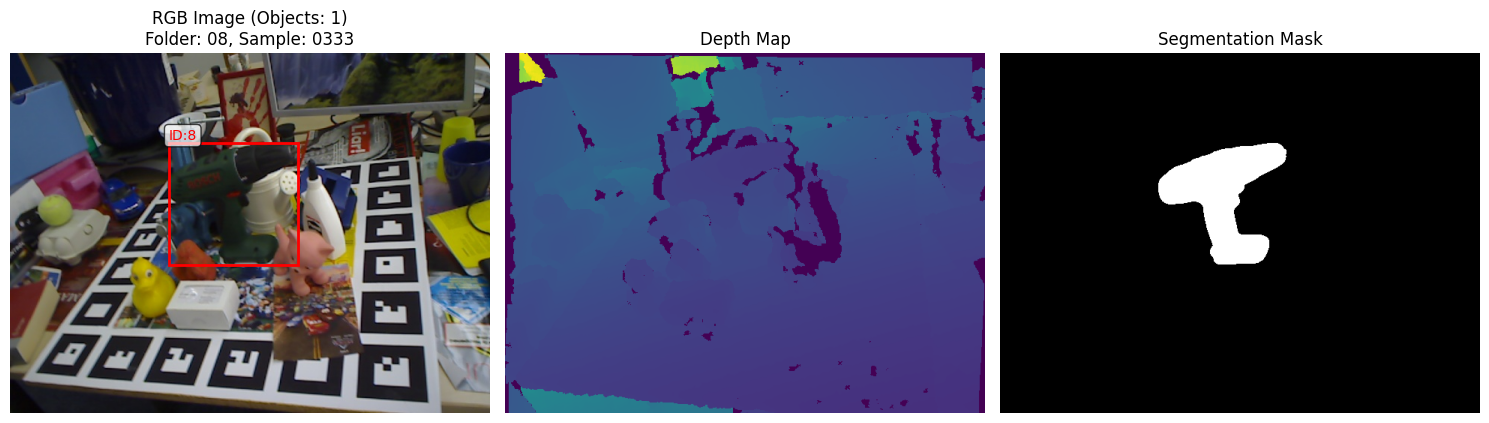


🎯 Found 1 object(s) in this image:

  Object #1 (ID: 8):
    Rotation matrix:
[[ 0.944834   0.23055   -0.232672 ]
 [-0.0449958 -0.612248  -0.789384 ]
 [-0.324445   0.756306  -0.568099 ]]
    Translation vector: [-23.146574 -50.11981  729.9714  ]
    Bounding Box [x, y, w, h]: [211. 120. 172. 162.]

📷 Camera Intrinsics:
[[572.4114    0.      325.2611 ]
 [  0.      573.57043 242.049  ]
 [  0.        0.        1.     ]]

Sample #2048


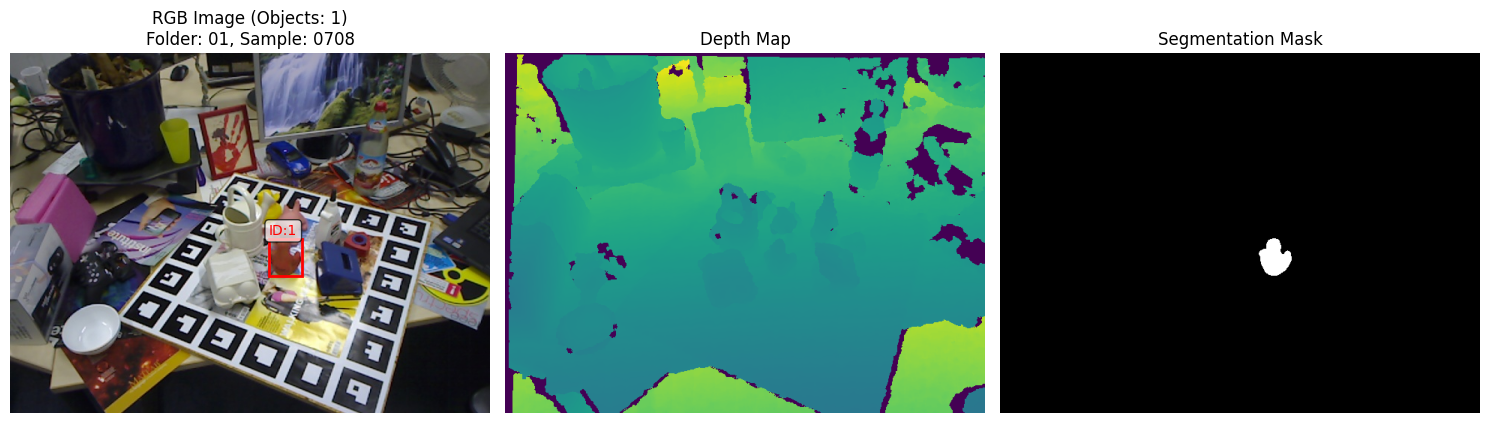


🎯 Found 1 object(s) in this image:

  Object #1 (ID: 1):
    Rotation matrix:
[[ 0.422367  -0.905425  -0.0425602]
 [-0.643055  -0.266222  -0.718057 ]
 [ 0.638817   0.330652  -0.694682 ]]
    Translation vector: [  72.78627    46.713745 1026.791   ]
    Bounding Box [x, y, w, h]: [345. 247.  44.  50.]

📷 Camera Intrinsics:
[[572.4114    0.      325.2611 ]
 [  0.      573.57043 242.049  ]
 [  0.        0.        1.     ]]

Sample #6679


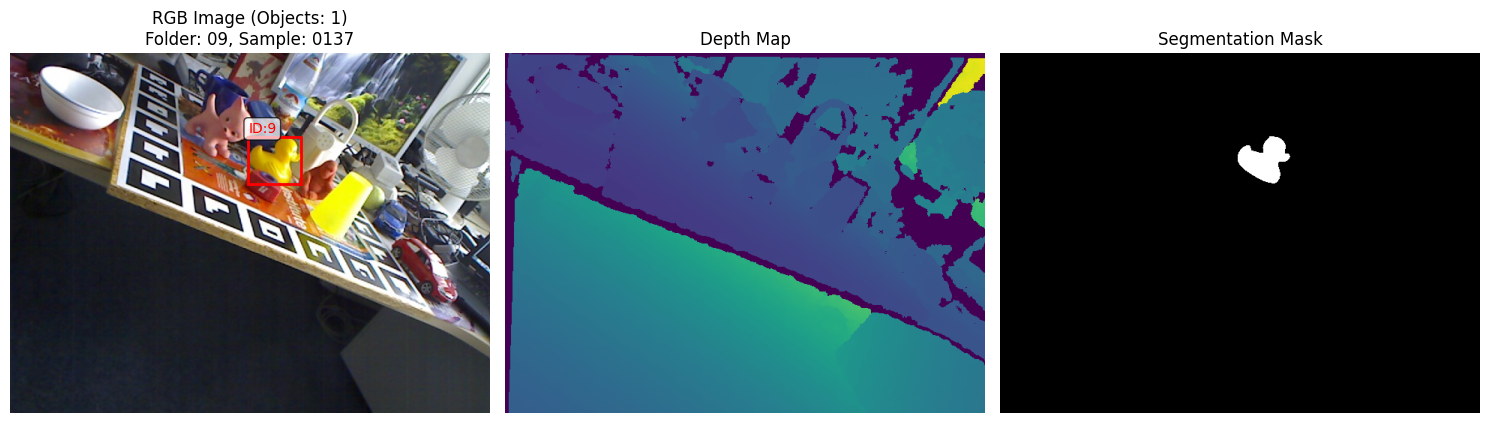


🎯 Found 1 object(s) in this image:

  Object #1 (ID: 9):
    Rotation matrix:
[[ 0.837774 -0.171057  0.518531]
 [ 0.342305 -0.575333 -0.742845]
 [ 0.425397  0.799832 -0.423445]]
    Translation vector: [  46.02745 -162.63255  880.7331 ]
    Bounding Box [x, y, w, h]: [317. 111.  70.  63.]

📷 Camera Intrinsics:
[[572.4114    0.      325.2611 ]
 [  0.      573.57043 242.049  ]
 [  0.        0.        1.     ]]


In [8]:
def visualize_sample(sample):
    """
    Visualizza un campione del dataset con TUTTI i bounding box.
    
    Args:
        sample: Un dizionario contenente i dati del campione
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # RGB Image
    rgb = sample['rgb'].permute(1, 2, 0).numpy()
    axes[0].imshow(rgb)
    axes[0].set_title(f"RGB Image (Objects: {sample['num_objects']})\nFolder: {sample['folder_id']:02d}, Sample: {sample['sample_id']:04d}")
    axes[0].axis('off')
    
    # Draw ALL bounding boxes with different colors
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple']
    if sample['num_objects'] > 0:
        for i, obj in enumerate(sample['objects']):
            bbox = obj['bbox'].numpy()
            x, y, w, h = bbox
            color = colors[i % len(colors)]
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
            axes[0].add_patch(rect)
            # Add object ID label
            obj_id = obj['obj_id']
            axes[0].text(x, y-5, f"ID:{obj_id}", color=color, fontsize=10, 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    # Depth Map
    if sample['depth'] is not None:
        depth = sample['depth'].numpy()
        axes[1].imshow(depth, cmap='viridis')
        axes[1].set_title("Depth Map")
        axes[1].axis('off')
    
    # Mask
    if sample['mask'] is not None:
        mask = sample['mask'].numpy()
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title("Segmentation Mask")
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Stampa informazioni su TUTTI gli oggetti
    print(f"\n🎯 Found {sample['num_objects']} object(s) in this image:")
    for i, obj in enumerate(sample['objects']):
        print(f"\n  Object #{i+1} (ID: {obj['obj_id']}):")
        print(f"    Rotation matrix:\n{obj['rotation'].numpy()}")
        print(f"    Translation vector: {obj['translation'].numpy()}")
        print(f"    Bounding Box [x, y, w, h]: {obj['bbox'].numpy()}")
    
    if sample['cam_K'] is not None:
        print("\n📷 Camera Intrinsics:")
        print(f"{sample['cam_K'].numpy()}")

# Visualizza 3 campioni casuali
indices = random.sample(range(len(train_dataset)), min(3, len(train_dataset)))

for idx in indices:
    print(f"\n{'='*80}")
    print(f"Sample #{idx}")
    print(f"{'='*80}")
    sample = train_dataset[idx]
    visualize_sample(sample)

## 6. Crea DataLoaders per il training

Questo codice crea oggetti DataLoader che wrappano i dataset:

- Internamente chiama probabilmente CustomDataset (come il primo blocco)

- Poi li wrappa in torch.utils.data.DataLoader

- Fornisce funzionalità aggiuntive:

- Batching automatico (batch_size=4)

- Shuffling del training set

- Parallelizzazione con num_workers

- Iterazione efficiente per il training

Usa quando:

- Stai facendo training/testing con PyTorch

- Hai bisogno di batching automatico

- Vuoi codice più conciso e standard

In [ ]:
# Crea train e test loaders
train_loader, test_loader = create_dataloaders(
    dataset_root=dataset_root,
    batch_size=4,
    num_workers=Config.NUM_WORKERS,
    train_ratio=Config.TRAIN_TEST_RATIO,
    seed=42
)

# Test di un batch
print("\n🔍 Testing a batch from train_loader...")
for batch in train_loader:
    print(f"   RGB batch shape: {batch['rgb'].shape}")
    if batch['depth'] is not None:
        print(f"   Depth batch shape: {batch['depth'].shape}")
    if batch['mask'] is not None:
        print(f"   Mask batch shape: {batch['mask'].shape}")
    print(f"   Batch contains {len(batch['folder_id'])} samples")
    break

✅ Dataset initialized: 12640 train samples
✅ Dataset initialized: 3160 test samples

📊 DataLoaders created:
   Training batches: 3160
   Test batches: 790

🔍 Testing a batch from train_loader...


## 7. Esplora il contenuto di gt.yml e info.yml

In [4]:
# Trova il primo gt.yml disponibile
gt_file = next(Config.LINEMOD_ROOT.rglob('gt.yml'), None)
info_file = next(Config.LINEMOD_ROOT.rglob('info.yml'), None)

if gt_file:
    print("📄 Ground Truth (gt.yml) content:")
    with open(gt_file, 'r') as f:
        gt_data = yaml.safe_load(f)
        # Il file YAML ha struttura: {sample_id: [list of objects]}
        if isinstance(gt_data, dict):
            first_key = list(gt_data.keys())[0]
            print(f"Sample ID: {first_key}")
            if isinstance(gt_data[first_key], list):
                print(yaml.dump(gt_data[first_key][0], default_flow_style=False))
            else:
                print(yaml.dump(gt_data[first_key], default_flow_style=False))
        else:
            print(yaml.dump(gt_data[0], default_flow_style=False))

if info_file:
    print("\n📄 Info (info.yml) content:")
    with open(info_file, 'r') as f:
        info_data = yaml.safe_load(f)
        # Il file YAML ha struttura: {sample_id: [list of objects]}
        if isinstance(info_data, dict):
            first_key = list(info_data.keys())[0]
            print(f"Sample ID: {first_key}")
            # Controlla se la chiave esiste e che tipo di dato è
            if first_key in info_data:
                if isinstance(info_data[first_key], list) and len(info_data[first_key]) > 0:
                    print(yaml.dump(info_data[first_key][0], default_flow_style=False))
                else:
                    print(yaml.dump(info_data[first_key], default_flow_style=False))
            else:
                print("Struttura non standard, mostra tutto:")
                print(yaml.dump(info_data, default_flow_style=False))
        else:
            print(yaml.dump(info_data[0] if isinstance(info_data, list) else info_data, default_flow_style=False))

📄 Ground Truth (gt.yml) content:
Sample ID: 0
cam_R_m2c:
- -0.061734
- 0.99215603
- -0.108696
- 0.77404898
- -0.0211604
- -0.63277203
- -0.630108
- -0.123199
- -0.76667202
cam_t_m2c:
- 103.57929656
- 49.49001985
- 1040.43577706
obj_bb:
- 344
- 228
- 77
- 84
obj_id: 4


📄 Info (info.yml) content:
Sample ID: 0
cam_K:
- 572.4114
- 0.0
- 325.2611
- 0.0
- 573.57043
- 242.04899
- 0.0
- 0.0
- 1.0
depth_scale: 1.0

